# 02456 Deep Learning - Acne Vulgaris vs Acne Rosacea

### Model: Retrain last layer of Inception V3 - With Spatial Transformer

#### Load the weights of the trained Inception V3 model, the weights of the trained localization net and evaluate some test images found using google image search (As provided training data is classified)

This notebook is used to show that the network works, by classifying an input image containing lesions of either Acne Vulgaris or Acne Rosacea. It is possible to use your own images by changing or adding images to one of the folders in the "test-images" folder. The class needs to follow the naming convention of the images already in the folders. for Rosacea images "rosacea_x.jpg" for vulgaris "vulgaris_x.jpg".

The implmentation for the Keras Spatial Transformer network was ported from Tensorflow to Keras by Github user "Hello2All". Repository is linked in the references below


Authors:
* s134859 Nicolai Mogensen
* s134569 Tobias Slot Jensen
* s144242 David Frich Hansen

References:
* SpatialTransformer Keras Implementation Hello2all: https://github.com/hello2all/GTSRB_Keras_STN

NOTE! Download these weights from here, and put them in your directory. Weights are aprox 120mb and exceeeds githubs filesize limit of 100mb
Weights: www.student.dtu.dk/~s134859/STnet.hdf5

##### Network was trained using a GTX 1080 Ti. If you experience OOM errors, it is probably because the network does not fit into your memory. 

In [1]:
# NOTE! Weights file was too big for github. Download the weights using the link above and put the file
# In the same directory as the notebook.
weights = "STnet.hdf5"

DIM = 299
import numpy as np
import glob
import os
from pathlib import Path
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
#from PIL import Image,ImageOps
from skimage.io import imread
from skimage.transform import resize
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
#import performance_measures
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json, Model
from keras.regularizers import l2
from keras.utils import np_utils
from spatial_transformer import SpatialTransformer
from keras.applications import InceptionV3
import pickle

from keras.callbacks import ModelCheckpoint,LambdaCallback,Callback
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
import keras.backend as K



Using TensorFlow backend.
/opt/miniconda3/envs/jupyterhub/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Model

In [2]:
# Reference "Hello2All"
def locnet():
    num_weights = 6
    b = np.zeros((2, 3), dtype='float32')
    
    # These parameters indicate zoom
    # Initialize these to be less than one to avoid infinite zoom-out
    b[0, 0] = 0.40
    b[1, 1] = 0.40
    
    W = np.repeat(np.array([0.0,0.0,0.0,0.0,0.0,0.0],dtype='float32'),num_weights).reshape(num_weights,6,order="F")
    weights = [W, b.flatten()]
    
    locnet = Sequential()

    locnet.add(Conv2D(16, (7, 7), padding='valid', input_shape=(299, 299, 3)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(32, (5, 5), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(128))
    locnet.add(Activation('relu'))
    locnet.add(Dense(64))
    locnet.add(Activation('relu'))
    locnet.add(Dense(num_weights))
    locnet.add(Activation('relu'))
    locnet.add(Dense(6, weights=weights))

    return locnet

def conv_model(input_shape=(299, 299,3)):
    
    # Part that contains ST-net
    model = Sequential()
    model.add(Lambda(
        lambda x: x,
        input_shape=input_shape,
        output_shape=input_shape))
    
    # Batch normalize to "relax" the weights and avoid explosion
    model.add(BatchNormalization())
    stnet = SpatialTransformer(localization_net=locnet(),
                                 output_size=(299,299)) #Resize to 299x299
    
    model.add(stnet)
    
    # Inception, load weights from HDF5 file, previously trained
    model_2 = Sequential()
    inc_v3 = InceptionV3(include_top=False, weights='imagenet', pooling='max',classes=2)
 
    # Don't train the layers, as everything is already trained
    for layer in inc_v3.layers:
        layer.trainable = False
    
    model_2.add(inc_v3)
    #model_2.add(BatchNormalization())
    output = Dense(2, activation='softmax')
    # Lets keep training the final layer, to obtain end-to-end
    output.trainable = True
    
    
    model_2.add(output)

    # Add the Inception Conv Net after the ST-net
    model.add(model_2)
    # Load the weights for the entire model
    model.load_weights(weights)
    
    return model

## Loading the weights can take time!

##### This cell loads the weights of the network. Can take several minutes.

In [3]:
model = conv_model()
model.summary()
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,metrics=['accuracy'])

# Intermediate model that lets us take out the transformed image to plot.
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer("spatial_transformer_1").output)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
spatial_transformer_1 (Spati (None, 299, 299, 3)       9512464   
_________________________________________________________________
sequential_3 (Sequential)    (None, 2)                 21806882  
Total params: 31,319,358
Trainable params: 9,516,568
Non-trainable params: 21,802,790
_________________________________________________________________


# Evaluation

##### Predictions on the test-images sourced using Google Image search.

In [4]:
files = []
for file_path in glob.iglob('**/*.jpg', recursive=True):
    files.append(file_path)

In [5]:
X = []
y = []
for file in files:
    patient = str(file).split("/")[-1]
    patient_type = str(file).split("/")[1]
    img = resize(imread(file),(299,299,3),mode="constant")
    #print(img.shape)
    X.append(img)
    if(patient_type == "vulgaris"):
        y.append(0)
    else:
        y.append(1)

X = np.asarray(X)
y = np.asarray(y)


Prediction: 0 Vulgaris [ 0.93092811  0.06907192]
True: 0 Vulgaris


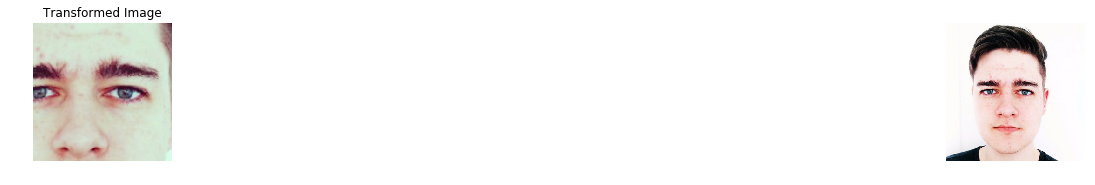


Prediction: 1 Rosacea [ 0.3824037   0.61759633]
True: 0 Vulgaris


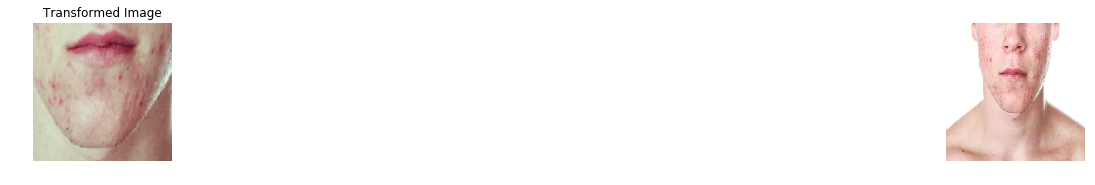


Prediction: 0 Vulgaris [ 0.75494784  0.2450522 ]
True: 0 Vulgaris


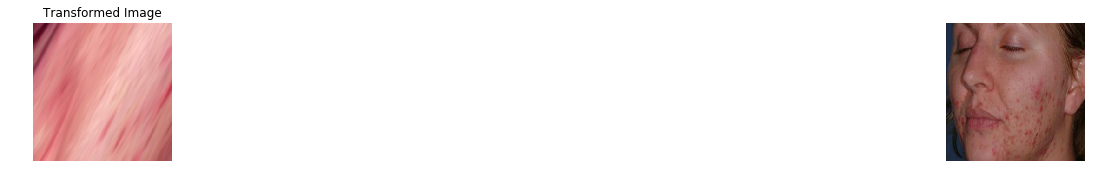


Prediction: 0 Vulgaris [ 0.61561334  0.38438663]
True: 0 Vulgaris


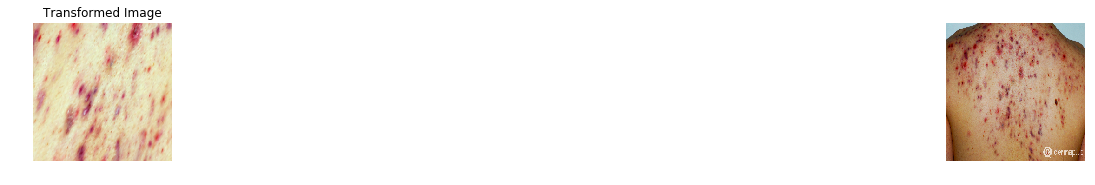


Prediction: 1 Rosacea [ 0.19755714  0.80244291]
True: 1 Rosacea


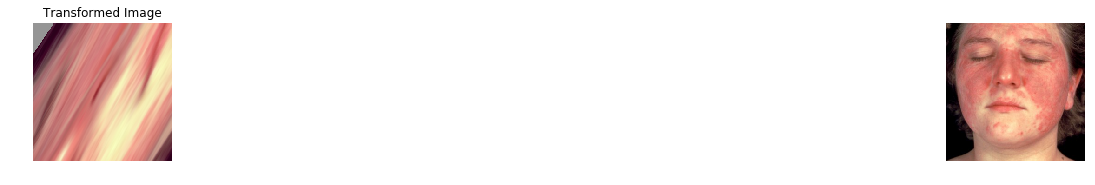


Prediction: 0 Vulgaris [ 0.87865841  0.12134157]
True: 1 Rosacea


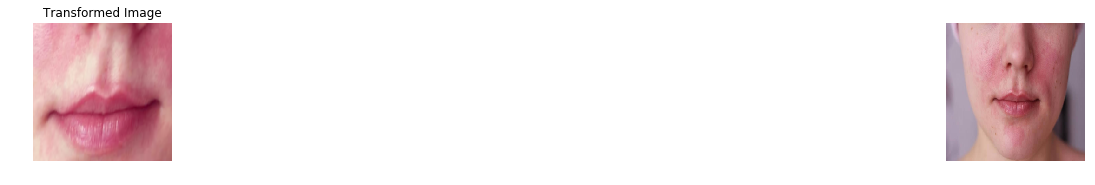


Prediction: 1 Rosacea [ 0.46057764  0.53942239]
True: 1 Rosacea


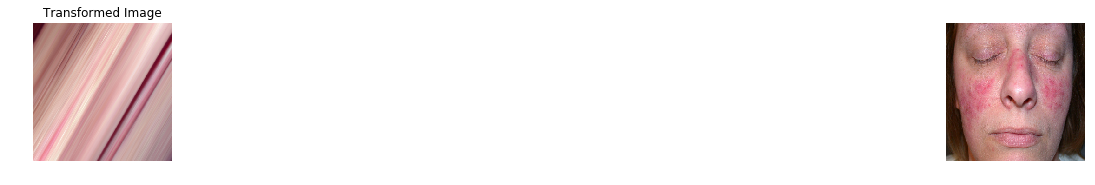


Prediction: 1 Rosacea [ 0.49840727  0.5015927 ]
True: 1 Rosacea


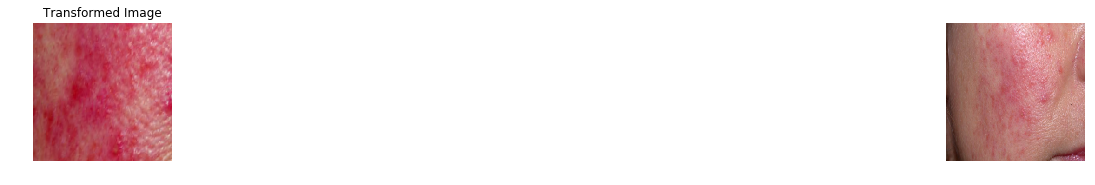


Prediction: 1 Rosacea [ 0.08973709  0.91026294]
True: 1 Rosacea


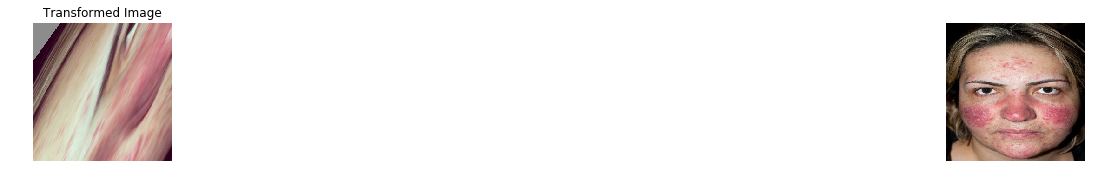

In [6]:
y_prob = model.predict(X) # Probabilities from Softmax
st_img = intermediate_layer_model.predict(X) # Transformed images
y_pred = np.argmax(y_prob,axis=1) # Classification

# subplot parameters
p1 = 1
p2 = 2
# Plot just the first 3 images
for i in range(len(X)):
    plt.figure(figsize = (30,30))
    plt.subplot(10,2,p1)
    # Normalize the images so we can plot them
    tmp_img = st_img[i]+np.abs(np.amin(st_img[i]))
    tmp_img = tmp_img/(np.amax(st_img[i])-np.amin(st_img[i]))
    #print("Shape of output:",tmp_img[i].shape)
    #print("Shape of st_img:",st_img[i])
    #print("Shape of input:",data["X_test"].shape)
    
    plt.title("Transformed Image")
    plt.imshow(tmp_img)
    
    #plt.imshow(st_img[i])

    plt.axis('off')
    plt.subplot(10,2,p2)
    plt.imshow(X[i])
    plt.axis('off')

    acne_pred = "Vulgaris"
    acne_true = "Vulgaris"
    if(y_pred[i] == 1):
        acne_pred = "Rosacea"
    if(y[i] == 1):
        acne_true = "Rosacea"

    print("\nPrediction: " + str(y_pred[i]) + " " + acne_pred + " " + str(y_prob[i]))
    print("True: " + str(y[i]) + " " + acne_true)
    plt.show()
    p1 += 2
    p2 += 2

##### As we can see, sometimes the transformations does not make sense. They can get really skewed and zoomed in. With better data, this implementation might have worked